# Лабораторная №3

**Задания:**
1. Выбрать временной ряд цен акций.
2. Подготовить данные для обучения моделей машинного обучения (нормализация, создание признаков).
3. Разделить данные на обучающую и тестовую выборки.
4. Реализовать и обучить следующие модели:
   - Логистическая регрессия
   - Машина опорных векторов
   - Модель случайного леса (Random Forest)
   - Градиентный бустинг (например, XGBoost)
5. Настроить гиперпараметры моделей с помощью кросс-валидации.
6. Сделать прогноз на тестовой выборке для каждой модели.
7. Сравнить результаты прогнозирования моделей между собой и с простыми методами (например, наивный прогноз).
8. Визуализировать результаты прогнозирования.
9. Проанализировать важность признаков для моделей, где это применимо.
10. Сделать выводы о эффективности различных подходов машинного обучения в прогнозировании цен акций.


# Подключение глобально необходимых библиотек


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import json

# Загрузка датасета

In [6]:
file_path = "aapl_us_2025.csv" 
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1984-09-07,0.099824,0.101049,0.098619,0.099824,9.859472e+07
1984-09-10,0.099824,0.100130,0.097424,0.099232,7.652559e+07
1984-09-11,0.100130,0.102846,0.100130,0.101049,1.804519e+08
1984-09-12,0.101049,0.101641,0.098007,0.098007,1.576401e+08
1984-09-13,0.103460,0.103754,0.103460,0.103460,2.455186e+08


In [ ]:
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['Volatility'] = df['Close'].rolling(window=5).std()
df.dropna(inplace=True)

scaler = StandardScaler()
features = ['Open', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_10', 'Volatility']
target = 'Close'
df[features] = scaler.fit_transform(df[features])

X_reg = df[features]
y_reg = df['Close']

df['Price_Up'] = (df['Close'] > df['Close'].shift(1)).astype(int)
df.dropna(inplace=True)
X_log = df[features]
y_log = df['Price_Up']

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, shuffle=False)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.2, shuffle=False)

df.head()

,Open,High,Low,Close,Volume,SMA_5,SMA_10,Volatility,Price_Up
Date,,,,,,,,,
1984-09-20,-0.497825,-0.497935,-0.497591,0.101938,-0.769787,-0.497643,-0.497623,-0.431000,0
1984-09-21,-0.497825,-0.497895,-0.497632,0.101049,-0.671609,-0.497658,-0.497621,-0.430743,0
1984-09-24,-0.497842,-0.497958,-0.497626,0.100130,-0.732357,-0.497687,-0.497619,-0.432274,0
1984-09-25,-0.497865,-0.497993,-0.497668,0.098007,-0.476363,-0.497709,-0.497625,-0.431999,0
1984-09-26,-0.497900,-0.497941,-0.497691,0.096821,-0.639144,-0.497728,-0.497627,-0.431381,0


## Обучение моделей
Для обучения моделей применялся GridSearchCv. С его помощью выполнялся перебор достаточно большого количества гипер-параметров и осуществлялась кросс-валидация. В качестве оценочной метрики для большинства моделей применялась MAE - среднее абсолютное значение ошибки. Для модели логистической регрессии, которая по сути представляет собой задачу классификации, в которой определяется один из двух классов: вырастет цена или нет, использовалась другая метрика Accuracy - точность.

Также при переборе параметров, обнаруженные оптимальные значения сохранялись в отдельные файлы в формате JSON, чтобы избежать случайной потери результатов длительных вычислений.

In [ ]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(n_jobs=-1),
        'params': {
            'penalty': ['l2'],  
            'solver': ['lbfgs'],  
            'C': [0.01, 0.1, 1, 10]  
        },
        'X_train': X_log_train,
        'X_test': X_log_test,
        'y_train': y_log_train,
        'y_test': y_log_test,
        'metric': accuracy_score
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.01, 0.1, 1, 10],  
            'kernel': ['linear', 'rbf'],  
            'epsilon': [0.1, 0.5],  
            'gamma': ['scale', 'auto']  
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    },
    'RandomForest': {
        'model': RandomForestRegressor(n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200],  
            'max_depth': [None, 10, 20],  
            'criterion': ['squared_error'],  
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [2, 5],  
            'min_samples_leaf': [1, 2]  
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    },
    'XGBoost': {
        'model': XGBRegressor(n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200],  
            'learning_rate': [0.01, 0.1, 0.2],  
            'max_depth': [3, 6, 10],  
            'subsample': [0.7, 1.0],  
            'colsample_bytree': [0.7, 1.0],  
            'gamma': [0, 0.1]  
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    }
}

results = {}

for title, config in models.items():
    print(f"Обучение модели: {title}")

    if title != 'XGBoost':
        grid = GridSearchCV(
            config['model'],
            config['params'],
            cv=3,  
            scoring='neg_mean_absolute_error' if title != 'LogisticRegression' else 'accuracy',
            n_jobs=-1
        )

        grid.fit(config['X_train'], config['y_train'])
        best_params = grid.best_params_
        predictions = grid.predict(config['X_test'])
    else:
        model_xgb = XGBRegressor(random_state=42)
        model_xgb.fit(X_reg_train, y_reg_train)
        best_params = model_xgb.get_params()
        predictions = model_xgb.predict(X_reg_test)

    metric_value = config['metric'](config['y_test'], predictions)
    results[title] = {
        'best_params': best_params,
        'metric_value': metric_value
    }

    with open(f'{title}_best_params.json', 'w') as f:
        json.dump({'best_params': best_params, 'metric_value': metric_value}, f, indent=4)

print("Обучение завершено!")


Обучение модели: LogisticRegression
Обучение модели: SVR
Обучение модели: RandomForest
Обучение модели: XGBoost
Обучение завершено!


## Прогнозирование
Затем на основе полученных параметров, были сформированы модели. Помимо них в качестве наивного прогноза применялись два метода: скользящее среднее за неделю, и случайное изменение цены на небольшое значение в пределах 1%.
На основе прогнозов каждой модели, были построены графики и вычислены метрики.

Обучение модели: SVR...
SVR MAE: 0.9722, RMSE: 1.2649


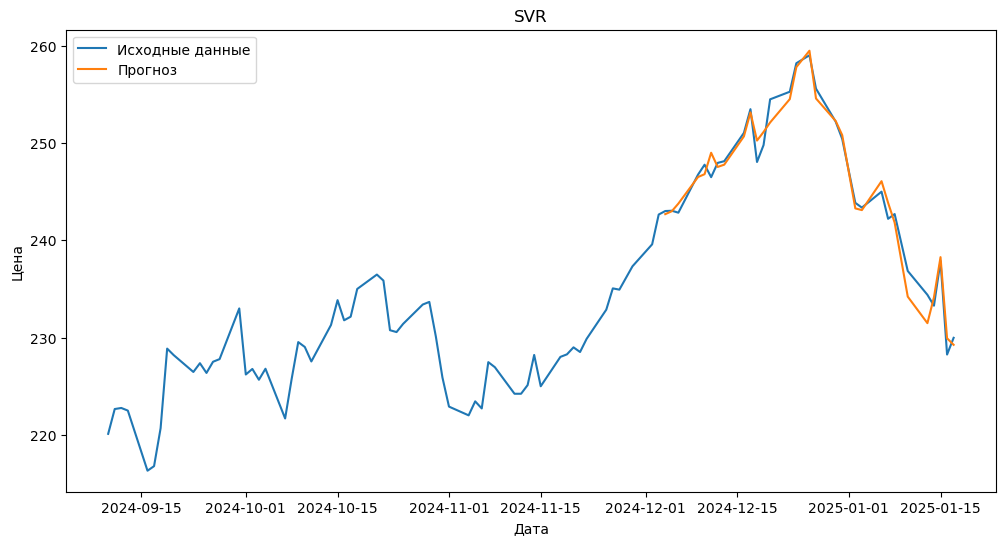

Обучение модели: Random Forest...
Random Forest MAE: 7.0181, RMSE: 8.7002


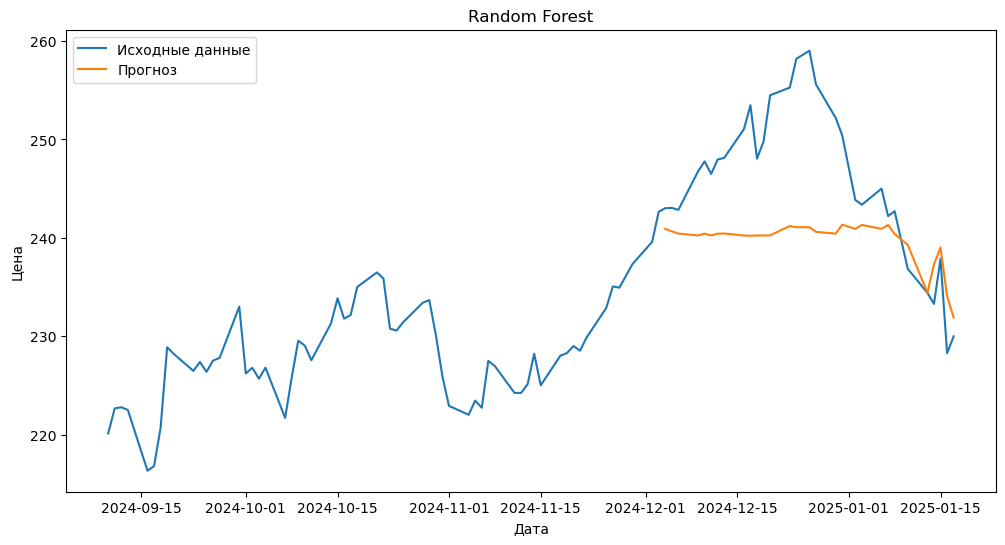

Обучение модели: XG Boost...
XG Boost MAE: 5.7052, RMSE: 7.6015


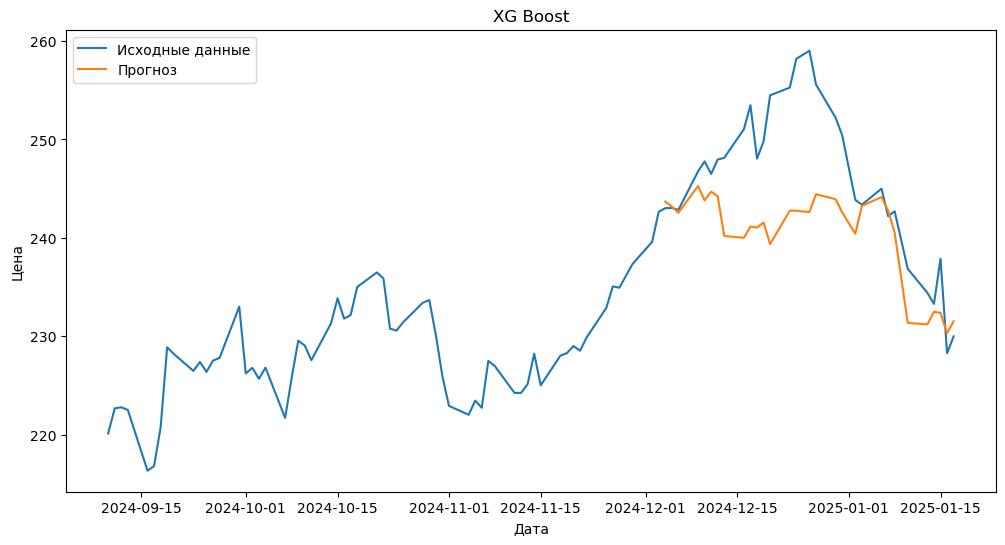

Обучение модели: Logistic Regression...
Logistic Regression Точность предсказания колебаний: 0.8333
Скользящее среднее (окно = 50) MAE: 7.5525, RMSE: 8.7477


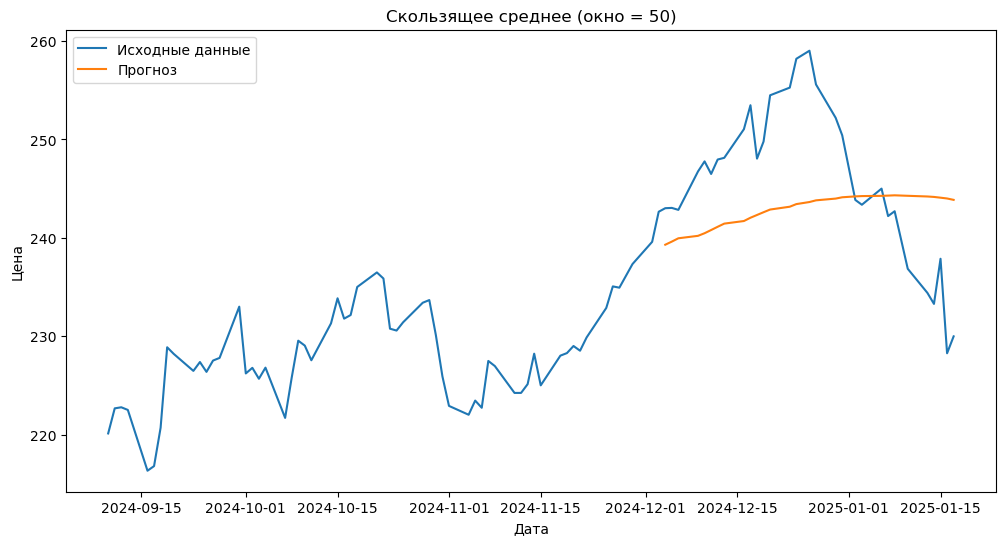

Случайные скачки MAE: 6.5016, RMSE: 7.2303


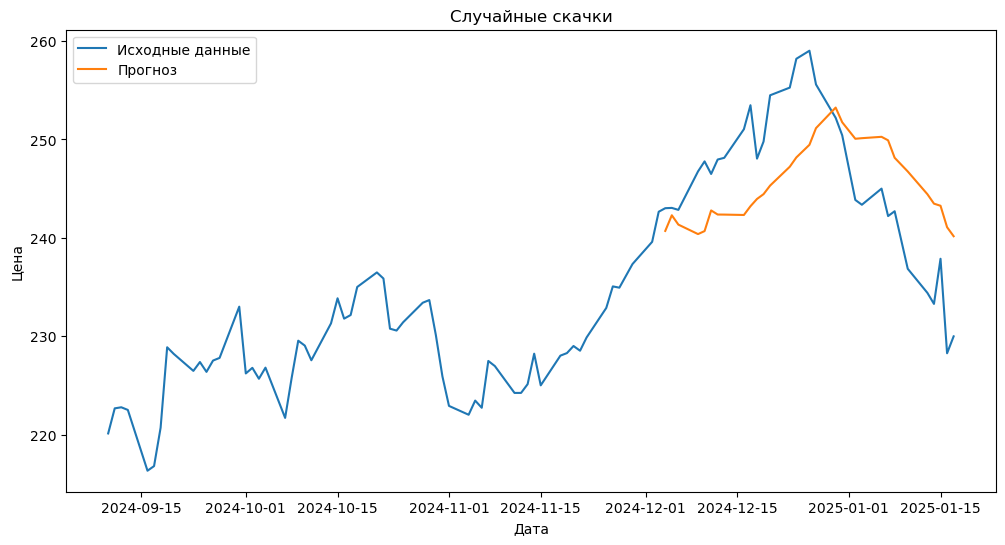

In [12]:
SVR_model = SVR(C=100, epsilon=0.01, gamma='auto', kernel='linear')
RF_model = RandomForestRegressor(
    n_jobs=-1, max_depth=15, criterion='squared_error',
    max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50
)
XGB_model = XGBRegressor(
    n_jobs=-1, colsample_bytree=0.7, gamma=0,
    learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0
)
LR_model = LogisticRegression(n_jobs=-1, C=10, penalty="l2", solver="lbfgs")

forecast_models = {
    "SVR": SVR_model,
    "Random Forest": RF_model,
    "XG Boost": XGB_model,
    "Logistic Regression": LR_model,
}

def forecast_price(forecast, title):
    if title == 'Logistic Regression':
        accuracy = accuracy_score(df['Price_Up'].iloc[-30:], forecast)
        print(f'{title} Точность предсказания колебаний: {accuracy:.4f}')
        return
    
    mae = mean_absolute_error(df[target].iloc[-30:], forecast)
    rmse = np.sqrt(mean_squared_error(df[target].iloc[-30:], forecast))
    print(f'{title} MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.iloc[-90:].index, df[target].iloc[-90:], label="Исходные данные")
    plt.plot(df.iloc[-30:].index, forecast, label="Прогноз")
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.legend()
    plt.show()

for title, model in forecast_models.items():
    print(f"Обучение модели: {title}...")
    if title == 'Logistic Regression':
        model.fit(df[features].iloc[:-30], df["Price_Up"].iloc[:-30])
        forecast = model.predict(df[features].iloc[-30:])
    else:
        model.fit(df[features].iloc[:-30], df[target].iloc[:-30])
        forecast = model.predict(df[features].iloc[-30:])
    
    forecast_price(forecast, title)

def forecast_with_moving_average():
    forecast_values = []
    current_window = df[target].iloc[-50:].tolist()
    
    for _ in range(30):
        new_value = np.mean(current_window)
        forecast_values.append(new_value)
        current_window.append(new_value)
        if len(current_window) > 50:
            current_window.pop(0)
    
    return forecast_values

forecast_price(forecast_with_moving_average(), "Скользящее среднее (окно = 50)")

def random_change_forecast():
    last_price = df[target].iloc[-31]
    forecast = []
    
    for _ in range(30):
        change_percentage = np.random.uniform(-0.01, 0.01)
        new_price = last_price * (1 + change_percentage)
        forecast.append(new_price)
        last_price = new_price
    
    return forecast

forecast_price(random_change_forecast(), "Случайные скачки")


## Оценка признаков
Большинство использованных моделей, уже хранят в себе важность признаков: Logistic Regression, Random forest, XG Boost. Остаётся только их извлечь. В отличие от остальных SVR такую информацию не содержит, и для оценки важности его признаков можно воспользоваться Permutation Importance. Permutation Importance — это метод, используемый в машинном обучении для определения важности отдельных признаков в отношении прогноза, сделанного моделью.

*Принцип работы: произвольным образом переставить или перетасовать один столбец в наборе датасета валидации, оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели.*

In [14]:
feature_importance_log = pd.DataFrame({
    'Признак': X_log_train.columns,
    'Важность': np.abs(LR_model.coef_[0])
}).sort_values(by='Важность', ascending=False)
print('Logistic Regression')
print(feature_importance_log)

feature_importance_rf = pd.DataFrame({
    'Признак': X_reg_train.columns,
    'Важность': RF_model.feature_importances_
}).sort_values(by='Важность', ascending=False)
print('Random forest')
print(feature_importance_rf)

feature_importance_xgb = pd.DataFrame({
    'Признак': X_reg_train.columns,
    'Важность': XGB_model.feature_importances_
}).sort_values(by='Важность', ascending=False)
print('XG Boost')
print(feature_importance_xgb)

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(SVR_model, X_reg_test, y_reg_test, n_repeats=10, random_state=42)
feature_importance_svr = pd.DataFrame({
    'Признак': X_reg_test.columns,
    'Важность': np.abs(perm_importance.importances_mean)
}).sort_values(by='Важность', ascending=False)
print('SVR')
print(feature_importance_svr)


Logistic Regression
      Признак   Важность
0        Open  29.704382
2         Low  24.901871
1        High  17.557363
4       SMA_5  12.151561
5      SMA_10   0.562525
3      Volume   0.082412
6  Volatility   0.068958
Random forest
      Признак  Важность
2         Low  0.374659
1        High  0.300374
0        Open  0.160057
4       SMA_5  0.093010
5      SMA_10  0.071884
6  Volatility  0.000008
3      Volume  0.000008
XG Boost
      Признак  Важность
4       SMA_5  0.420044
2         Low  0.291989
0        Open  0.136091
1        High  0.125332
5      SMA_10  0.026491
6  Volatility  0.000026
3      Volume  0.000026
SVR
      Признак      Важность
2         Low  1.451479e+00
1        High  1.446299e+00
0        Open  1.044439e+00
4       SMA_5  2.282838e-03
5      SMA_10  4.460382e-04
6  Volatility  6.564454e-07
3      Volume  7.287214e-10


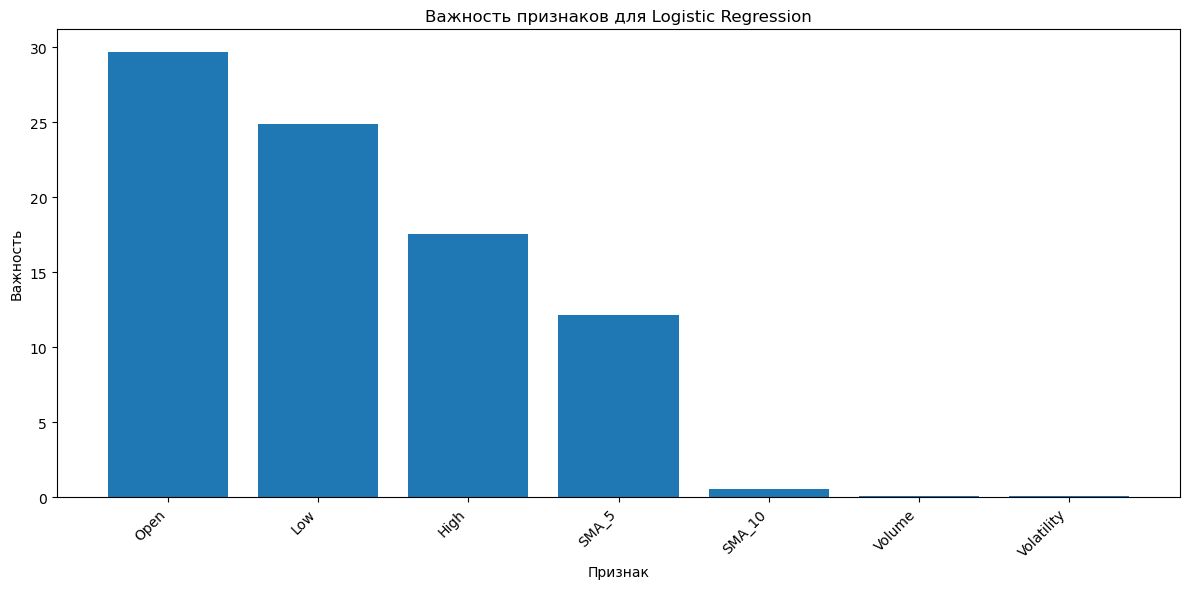

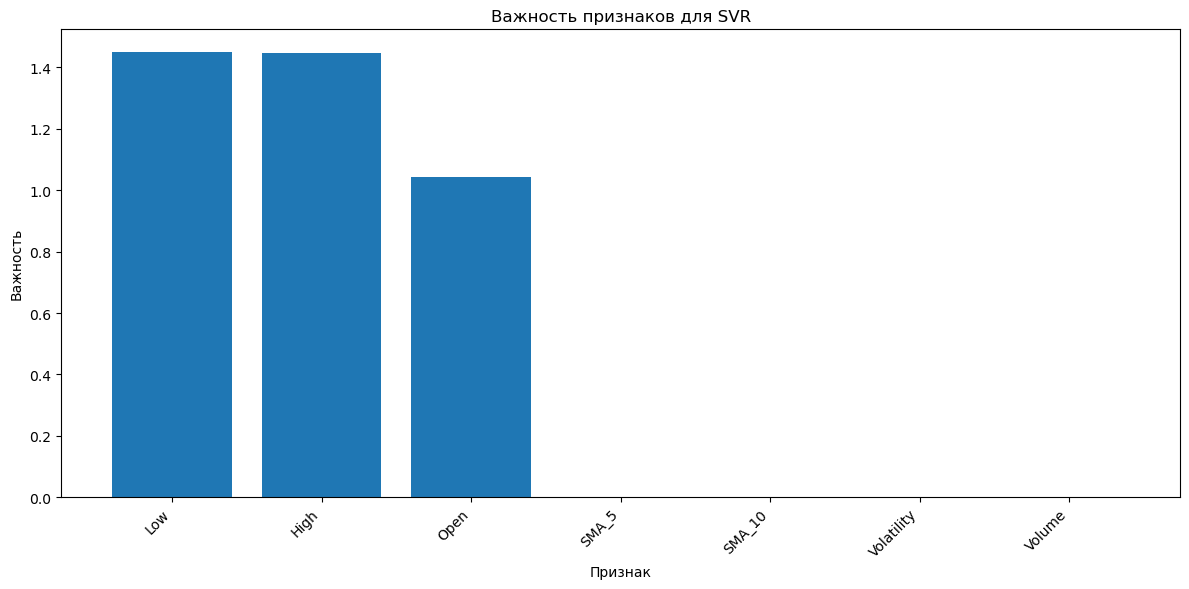

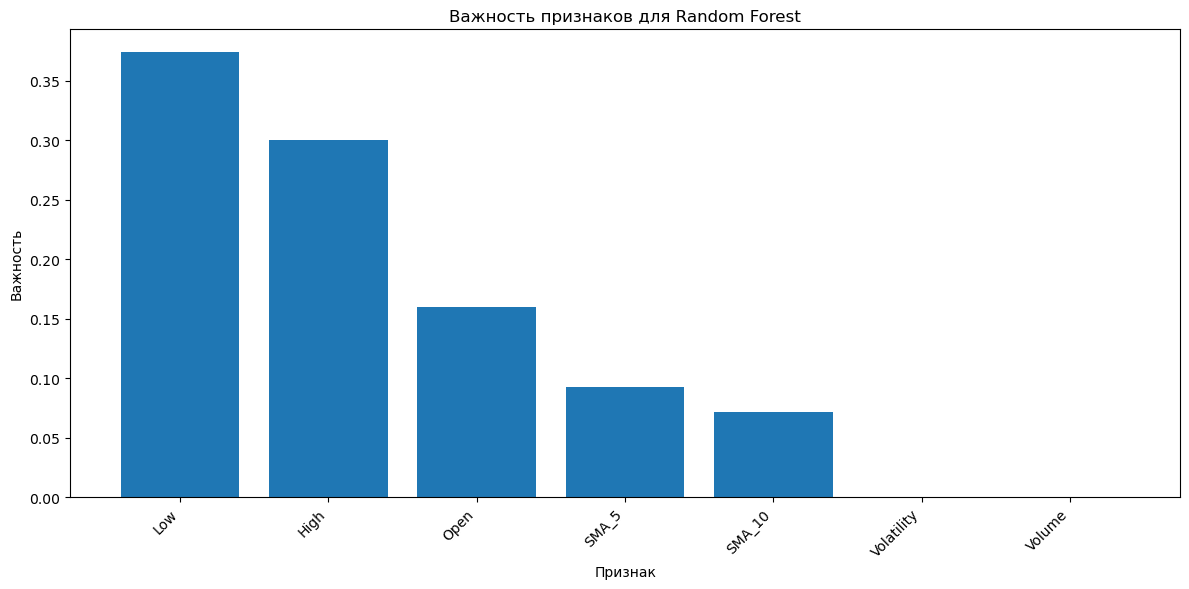

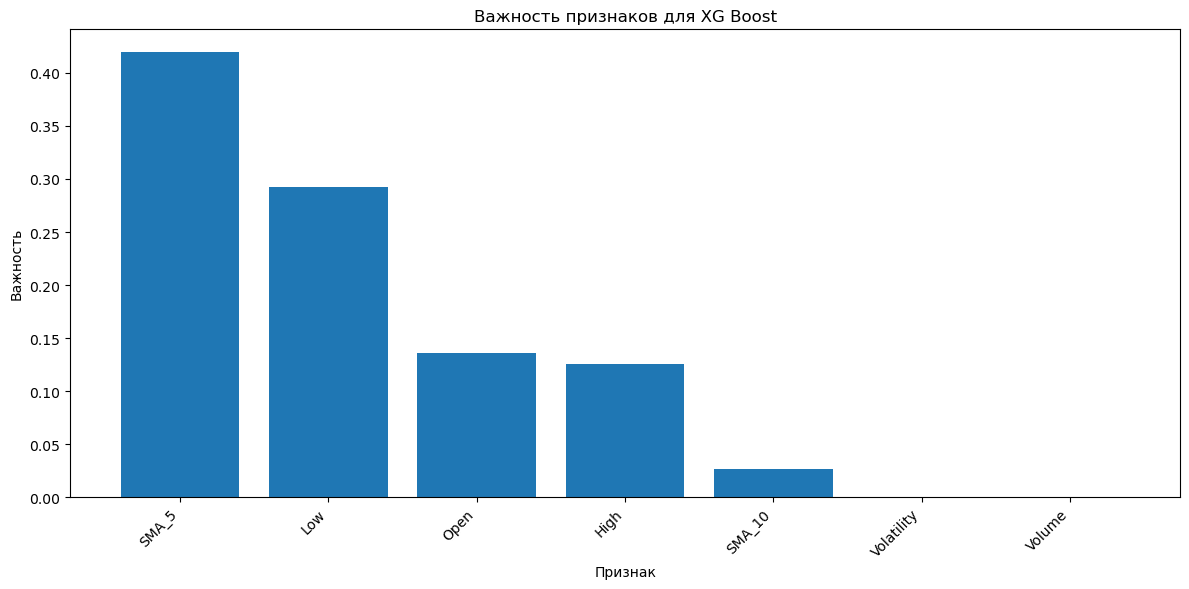

In [15]:
def plot_feature_importance(feature_importance, model_name):
    features = feature_importance['Признак']
    importances = feature_importance['Важность']
    plt.figure(figsize=(12, 6))
    plt.bar(features, importances)
    plt.xlabel('Признак')
    plt.ylabel('Важность')
    plt.title(f'Важность признаков для {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_feature_importance(feature_importance_log, 'Logistic Regression')
plot_feature_importance(feature_importance_svr, 'SVR')
plot_feature_importance(feature_importance_rf, 'Random Forest')
plot_feature_importance(feature_importance_xgb, 'XG Boost')


# Заключение
Наилучшие результаты в задаче регрессии показала модель SVR. Она продемонстрировала наименьшую абсолютную погрешность среди всех протестированных моделей, что делает её наиболее подходящей для прогнозирования цен актива.

Остальные модели справились с задачей хуже. Если расположить их в порядке успешности, получится следующий ряд: SVR > Скользящее среднее > Логистическая регрессия > XG Boost ~ Random Forest > Случайные скачки.

Скользящее среднее, несмотря на свою простоту, показало результаты лучше, чем более сложные модели XG Boost и Random Forest. Это свидетельствует о том, что данные обладают сильным трендом, который эти модели не смогли эффективно уловить. XG Boost и Random Forest оказались неприменимыми в данной задаче, так как их прогнозы не учитывали общий рост цен. Модель случайных скачков демонстрировала нестабильные результаты, зависящие от конкретного прогона.

Логистическая регрессия показала достаточно хороший результат в задаче бинарной классификации направлений движения цены, достигнув точности около 80%.

Анализ важности признаков в различных моделях дал интересные результаты:

- SVR сосредоточилась на признаках High, Low и Open, причём High и Low оказались самыми значимыми.
- Random Forest отдавала наибольшую значимость High, затем Low, а потом с заметным отрывом шли Open, SMA_10 и SMA_5.
- XG Boost построил "лесенку" из признаков High > Low > SMA_5 > Open, практически не используя SMA_10.
- Логистическая регрессия, в отличие от других моделей, задействовала Volatility и Volume, хотя и с меньшей значимостью.

# Вывод
Анализ важности признаков показывает, что некоторые из них можно исключить без потери качества прогноза. Исключение ненужных признаков повысит скорость вычислений и, возможно, улучшит качество моделей. В данной задаче можно с уверенностью отбросить OpenInt (число открытых сделок на начало дня), Volatility и Volume, так как они оказались наименее значимыми для всех моделей.